In [1]:

from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)




Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


# Generate dataset


In [10]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=3, quick_run=False, num_of_input_chnls=2)

INFO - Preparing experimental handlers. This may take a while. Be patient...
INFO - Ready. Loop through patient ids.


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


# Generate distance transform and target ROIs

In order to train our detector we first need to generate 

    (1) Distance transform maps: For each slice of a patient study, we compute for each target structure (tissue) the distance between the target structure and each voxel in the slice (i.e. for ACDC dataset for each slice we compute dt maps for RV, Myo and LV for both cardiac phases. The result is stored in the dt_maps dictionary where each map has shape [num_of_classes, w, h, #slices];
    
    (2) Target region of interest (ROI): For each slice of a patient study we compute the target ROIs that the detector should find based on the automatic segmentations and the uncertainty maps. The ROIs are labeled in the each slice per tissue class. Hence, we store again a numpy array of shape [num_of_classes, w, h, #slices] (self.target_roi_maps)
    
  

In [3]:
seg_exper_ensemble.seg_exper_handlers[3].generate_dt_maps(patient_id="patient065")
print("Ready")

  0%|          | 0/25 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00,  9.24it/s]


INFO - Successfully loaded 25 ED/ES patient pairs
Ready


In [4]:
seg_exper_ensemble.seg_exper_handlers[3].generate_target_rois_for_learning(patient_id="patient065", 
                                                                           mc_dropout=False)
print("Ready")

Ready


In [3]:
# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. 
TEST_FOLD = 3

seg_exper_handler = seg_exper_ensemble.seg_exper_handlers[TEST_FOLD]
seg_exper_handler.get_test_set()

  0%|          | 0/25 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00,  9.43it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


### If we have generated dt-maps and target rois, we can load (for all or a couple of patients) the required objects by using the segmentation ensemble

In [4]:
type_of_map = "e_map"
# list_with_patients = ["patient018", "patient056", "patient098", "patient100"]
list_with_patients = seg_exper_handler.test_set.trans_dict.keys()
seg_exper_ensemble.prepare_handlers(fold_id=TEST_FOLD, type_of_map=type_of_map, force_reload=True)
print("Ready")

Ready


In [8]:
from scipy.ndimage.measurements import label
from scipy import ndimage

def find_connected_components(label_slice):
    structure = [[0, 1, 0],
                     [1, 1, 1],
                     [0, 1, 0]]
    cc_labels, n_comps = label(label_slice, structure=structure)
    roi_sizes = np.zeros(n_comps).astype(np.int)
    roi_boxes = np.zeros((n_comps, 4))
    for i_comp in np.arange(1, n_comps + 1):
        roi_sizes[i_comp - 1] = np.count_nonzero(cc_labels == i_comp)
        roi_slice_x, roi_slice_y = ndimage.find_objects(cc_labels == i_comp)[0]
        # roi_slice_x contains [x_low, x_high], roi_slice_y contains [y_low, y_high]
        # roi boxes [Nx4] with x_low, y_low, x_high, y_high
        roi_boxes[i_comp - 1] = np.array([roi_slice_x.start - 1, roi_slice_y.start - 1, 
                                          roi_slice_x.stop , roi_slice_y.stop ])
    return n_comps, roi_sizes, roi_boxes, cc_labels

### Create bounding boxes around target voxels (areas)

In [9]:
slice_cls_stats = np.zeros(8)
roi_stats = np.zeros(8)
apex_base = 0
patients = 0
roi_sizes = []
roi_con_components = []
roi_size_con_components = []
# total slices, slices with roi, slices without roi (index 1 + 2 must sum to index 0)
total_slices = np.zeros(3)
patient_bboxes = {}

for p_id, target_roi_map in seg_exper_handler.target_roi_maps.iteritems():
    
    nclasses, w, h, nslices = target_roi_map.shape
    new_patient = True
    bboxes_per_slice = {}
    print("INFO - Process patient {} ({}/{})".format(p_id, nclasses, nslices))
    # I was here. we need to concatenate the bboxes for a patient. then test them below when plotting slice
    for slice_id in np.arange(nslices):
        bboxes_per_class = {}
        total_slices[0] += 1
        new_slice = True
        for cls_idx in np.arange(1, nclasses):
            bboxes = np.empty((0, 4))
            if cls_idx <= 3:
                phase = 0
            else:
                phase = 1
            roi_slice = target_roi_map[cls_idx, :, :, slice_id]
            roi_count = np.count_nonzero(roi_slice)
            if roi_count != 0:
                roi_sizes.append(roi_count)
                roi_num_con_comps, roi_size, roi_boxes, _ = find_connected_components(roi_slice)
                # roi_boxes is a Nx4 matrix where N=#rois
                if roi_num_con_comps > 0:
                    # print(roi_size)
                    bboxes = np.concatenate((bboxes, roi_boxes)) if bboxes.size else roi_boxes
                roi_con_components.append(roi_num_con_comps)
                roi_size_con_components.append(roi_size)
                    
                if new_patient:
                    patients += 1
                    new_patient = False
                if (slice_id == 0 or slice_id == nslices - 1) and new_slice:
                    apex_base += 1
                if new_slice:
                    total_slices[1] += 1
                new_slice = False
                
                roi_stats[cls_idx] += roi_count
                slice_cls_stats[cls_idx] += 1
            bboxes_per_class[cls_idx] = bboxes
            
        bboxes_per_slice[slice_id] = bboxes_per_class
        if new_slice:
            total_slices[2] += 1
    patient_bboxes[p_id] = bboxes_per_slice
    
    

INFO - Process patient patient001 (8/10)
INFO - Process patient patient002 (8/10)
INFO - Process patient patient003 (8/10)
INFO - Process patient patient004 (8/10)
INFO - Process patient patient005 (8/10)
INFO - Process patient patient021 (8/10)
INFO - Process patient patient022 (8/7)
INFO - Process patient patient023 (8/9)
INFO - Process patient patient024 (8/8)
INFO - Process patient patient025 (8/9)
INFO - Process patient patient041 (8/6)
INFO - Process patient patient042 (8/9)
INFO - Process patient patient043 (8/12)
INFO - Process patient patient044 (8/9)
INFO - Process patient patient045 (8/8)
INFO - Process patient patient061 (8/9)
INFO - Process patient patient062 (8/10)
INFO - Process patient patient063 (8/8)
INFO - Process patient patient064 (8/10)
INFO - Process patient patient065 (8/8)
INFO - Process patient patient081 (8/17)
INFO - Process patient patient082 (8/16)
INFO - Process patient patient083 (8/6)
INFO - Process patient patient084 (8/12)
INFO - Process patient patie

In [19]:
arr_width = []
arr_height = []
for p_id, p_bboxes in patient_bboxes.iteritems():
    for slice_idx, p_bboxes_slice in p_bboxes.iteritems():
        for cls_idx, p_bboxes_cls in p_bboxes_slice.iteritems():
            if p_bboxes_cls.size:
                for b_idx in np.arange(p_bboxes_cls.shape[0]):
                    bbox = p_bboxes_cls[b_idx]
                    bb_width = bbox[2] - bbox[0]
                    bb_height = bbox[3] - bbox[1]
                    arr_width.append(bb_width)
                    arr_height.append(bb_height)

print(len(arr_width), len(arr_height))                
print(np.median(np.array(arr_width)), np.median(np.array(arr_height)))
print(np.mean(np.array(arr_width)), np.mean(np.array(arr_height)))
print(np.std(np.array(arr_width)), np.std(np.array(arr_height)))
print("median-ROI voxel counts {:.2f}".format(np.median(np.array(roi_sizes))))

509 509
3.0 3.0
5.57956777996 6.14538310413
7.58449813725 9.55114879587
median-ROI voxel counts 8.50


In [10]:
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, \
    generate_binary_structure
    
def auto_pred_border(reference, connectivity=1):
    reference = np.atleast_1d(reference.astype(np.bool))
    # binary structure
    footprint = generate_binary_structure(reference.ndim, connectivity)
    if 0 == np.count_nonzero(reference):
        raise RuntimeError('The reference array does not contain any binary object.')

    reference_border = np.logical_xor(reference, binary_erosion(reference, structure=footprint, iterations=1))
    return reference_border

In [11]:
import matplotlib.patches as patches

def bbox_to_patch(bbox, box_color='r', linewidth=1):
    # bbox is [1x4] [x_low, y_low, x_high, y_high]
    # x_high, y_low for imshow
    xy_left = tuple((bbox[1], bbox[0]))
    height = bbox[2] - bbox[0] 
    width = bbox[3] - bbox[1] 
    rect = patches.Rectangle(xy_left, width, height, linewidth=linewidth, edgecolor=box_color, facecolor='none')
    
    return rect

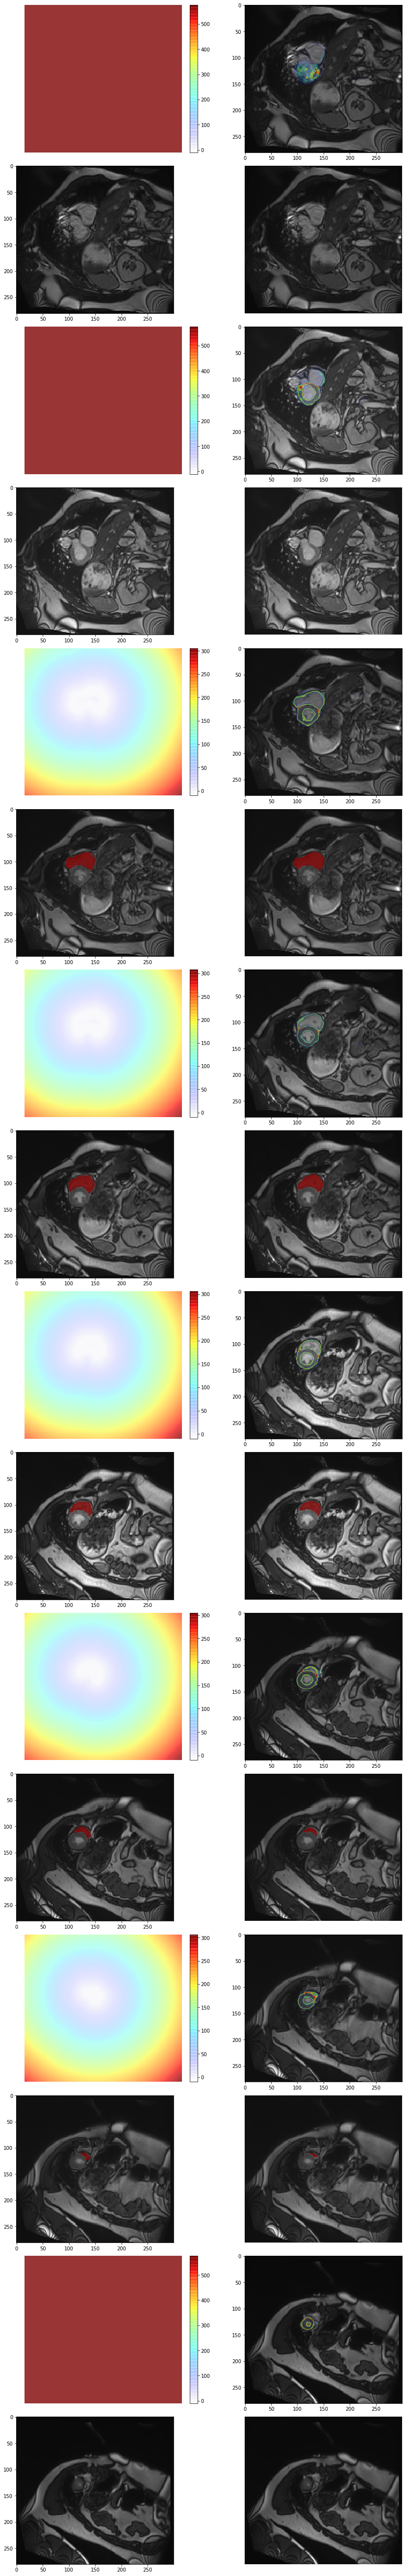

In [12]:

patient_id = "patient065"

image, labels = seg_exper_handler.test_set.get_test_pair(patient_id)
pred_probs = seg_exper_handler.pred_prob_maps[patient_id]
num_of_classes, w, h, batch_size = labels.shape

bboxes = patient_bboxes[patient_id]

# print(mean_pred_probs[1])
# batch_size = 4

width = 16
height = batch_size * 12
columns = 4
rows = batch_size * 4
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

phase = 0
target_class = 1
cls_offset = phase * 4
cls_idx = cls_offset + target_class

for idx in np.arange(batch_size):
    image_with_padding = image[phase, :, :, idx]
    image_slice = ACDC2017DataSet.remove_padding(image_with_padding)
    auto_pred = seg_exper_handler.pred_labels[patient_id]
    auto_pred_slice = auto_pred[cls_idx, :, :, idx]
    bboxes_slice = bboxes[idx][cls_idx]
    if 0 != np.count_nonzero(auto_pred_slice):
        auto_pred_slice_border = auto_pred_border(auto_pred_slice)
    reference_slice = labels[cls_idx, :, :, idx]
    seg_errors_slice = reference_slice != auto_pred_slice
    umap = seg_exper_handler.entropy_maps[patient_id]
    umap_slice = umap[phase, :, :, idx]
    umap_slice_copy = copy.deepcopy(umap_slice)
    dt_slices = seg_exper_handler.get_dt_maps(patient_id)
    dt_slice = dt_slices[cls_idx, :, : , idx]
    # negative_idx = dt_slice <= 0
    # dt_slice[negative_idx] = -20
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    # ax1.imshow(image_slice, cmap=cm.gray)
    # ax1.imshow(reference_slice, cmap=mycmap)
    ax1_dt_plot = ax1.imshow(dt_slice, cmap=mycmap, vmin=-10.)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice, cmap=cm.gray)
    ax2.imshow(umap_slice, cmap=mycmap)
    if bboxes_slice.size:
        for i_box in np.arange(bboxes_slice.shape[0]):
            rect = bbox_to_patch(bboxes_slice[i_box], 'b', linewidth=1)
            ax1.add_patch(rect)
            rect = bbox_to_patch(bboxes_slice[i_box], 'b', linewidth=2)
            ax2.add_patch(rect)
            if idx == 1:
                print(rect.get_height(), rect.get_width())
                bb = np.array([50, 100, 60, 110])
                rect = bbox_to_patch(bb, 'r', linewidth=4)
                ax2.add_patch(rect)
    ax1.set_aspect('auto')
    fig.colorbar(ax1_dt_plot, ax=ax1, fraction=0.046, pad=0.04)
    # plt.axis("off")
    
    row += 2 
    target_roi_slice = seg_exper_handler.target_roi_maps[patient_id][cls_idx, :, :, idx]
    ax3 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax3.imshow(image_slice, cmap=cm.gray)
    ax3.imshow(reference_slice, cmap=mycmap)
    target_roi_slice[target_roi_slice == 1] = 1
    ax1.imshow(target_roi_slice, cmap=mycmap)
    
    if 0 != np.count_nonzero(target_roi_slice):
        ax1.set_title("Region {}".format(np.count_nonzero(target_roi_slice)))
        ax2_dt_plot = ax2.imshow(target_roi_slice, cmap=mycmap)
    ax4 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax4.imshow(image_slice, cmap=cm.gray)
    ax4.imshow(auto_pred_slice, cmap=mycmap)
    umap_slice_copy[umap_slice_copy <= 0.1] = 0
    # ax4.imshow(umap_slice_copy, cmap=mycmap)
    plt.axis("off")
    row += 2

ROI objects 1


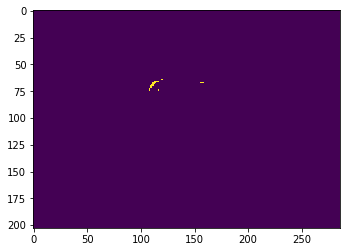

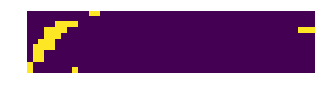

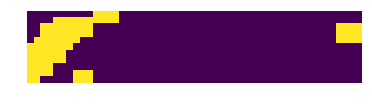

slice(64L, 75L, None)


In [20]:
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

# im = target_rois[patient_id][cls_idx, :, :, -1]

im = seg_exper_handler.target_roi_maps[patient_id][cls_idx, :, :, -5]

plt.imshow(im)


# Now that we have only one connected component, extract it's bounding box
roi_objects = ndimage.find_objects(im==1)
print("ROI objects {}".format(len(roi_objects)))
slice_x, slice_y = roi_objects[0]
roi = im[slice_x, slice_y]

plt.figure(figsize=(4, 2))
plt.axes([0, 0, 1, 1])
plt.imshow(roi)
plt.plot()
plt.axis('off')

plt.show()

struct2 = ndimage.generate_binary_structure(3, 3)
roi_after = binary_dilation(roi, structure=np.ones((3,3))).astype(roi.dtype)
# roi_after = binary_dilation(roi_after, structure=struct2).astype(roi.dtype)
plt.imshow(roi_after)
plt.axis('off')

plt.show()

print(slice_x)

In [ ]:
patient_id = "patient100"

image, labels = seg_exper_handler.test_set.get_test_pair(patient_id)
num_of_classes, w, h, batch_size = labels.shape

width = 16
height = batch_size * 12
columns = 4
rows = batch_size * 4
column = 0
row = 0
fig = plt.figure(figsize=(width, height))


for idx in np.arange(batch_size):
    image_with_padding = image[0, :, :, idx]
    image_slice_es = ACDC2017DataSet.remove_padding(image_with_padding)
    image_with_padding = image[1, :, :, idx]
    image_slice_ed = ACDC2017DataSet.remove_padding(image_with_padding)
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax1.set_title("ES - slice {}".format(idx+1))
    ax1.imshow(image_slice_es, cmap=cm.gray)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice_ed, cmap=cm.gray)
    ax2.set_title("ED - slice {}".format(idx+1))
    plt.axis("off")
    row += 2

fig_path = os.path.join(seg_exper_handler.exper.config.root_dir,
                                      os.path.join(seg_exper_handler.exper.output_dir, config.figure_path))
fig_path = os.path.join(fig_path, patient_id)
fig_name = patient_id + "_all_slices.pdf"
fig_name = os.path.join(fig_path, fig_name)
plt.savefig(fig_name, bbox_inches='tight')
print("INFO - Successfully saved fig %s" % fig_name)